This is the minimal set of code that I have extracted from the notebook written by https://github.com/fmobrj.

Memory occupancy by batch size:

| Batch Size | GPU Memory Usage |
|------------|------------------|
| 1 | 1021MiB |
| 2 | 1407MiB |
| 3 | 1791MiB |
| 4 | 2165MiB |
| 5 | 2595MiB |
| 6 | 3041MiB |
| 7 | 3449MiB |

I tested these numbers when running `lr_find`. With a batch size of 7 the GPU Memory Usage is 3465MiB when training.

I have a 4GB graphics card so I can only go up to 7. Around 500MiB are taken by the OS.

In [1]:
from fastai.vision import *

import pandas as pd

import torch
from torch.optim import Optimizer

from efficientnet_pytorch import EfficientNet

In [2]:
PROJECT_ROOT = Path('.').absolute().parents[0]
DATA_FOLDER = PROJECT_ROOT / 'data' / 'processed'
TRAIN_CSV = DATA_FOLDER / 'train.csv'
VALID_CSV = DATA_FOLDER / 'valid.csv'
CARS_FOLDER = DATA_FOLDER / 'car_data'

MODEL_NAME = 'efficientnet-b3'
IMAGE_SIZE = EfficientNet.get_image_size(MODEL_NAME)
BATCH_SIZE = 7

### Create the Learner

In [3]:
np.random.seed(42)
data = (
    ImageList.from_folder(CARS_FOLDER/'train')
        .split_by_rand_pct(0.1)
        .label_from_folder()
        .transform(tfms=get_transforms(), size=IMAGE_SIZE, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BATCH_SIZE)
        .normalize(imagenet_stats)
)

In [4]:
model = EfficientNet.from_pretrained(MODEL_NAME)
model.add_module('_fc',nn.Linear(1536, 196))

Loaded pretrained weights for efficientnet-b3


In [5]:
learn = Learner(
    data,
    model,
    loss_func=nn.CrossEntropyLoss(),
    metrics=[accuracy],
    opt_func=torch.optim.RMSprop
)

In [6]:
learn.split([
    [learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:12]],
    [learn.model._blocks[12:],learn.model._conv_head], 
    [learn.model._bn1,learn.model._fc]
]) ; None

### Train the Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 9.12E-08


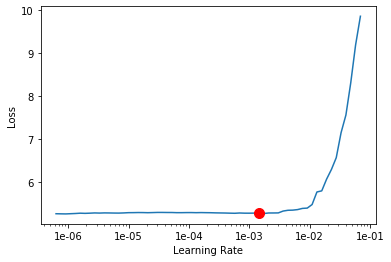

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [8]:
LEARNING_RATE = 1.45E-03

In [9]:
learn.fit_one_cycle(1, max_lr=slice(LEARNING_RATE/100,LEARNING_RATE))

In [ ]:
learn.save('stage-1-cars-efficientnet-b3')

In [ ]:
learn.load('stage-1-cars-efficientnet-b3')